# Customized Markov Chain
A "stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event"
*[Source](https://en.wikipedia.org/wiki/Markov_chain)*<br>

**Author: Tashi Stirewalt (tashi.stirewalt@wsu.edu)**

## Data Preparation

### Set up paths

In [1]:
from os import getcwd
from pathlib import Path

Set up Path variables to used files and directories

In [2]:
# Get current working directory as Path variable
cwd_path = Path(getcwd())

# Set up path to directory for data files

data_dir_path = cwd_path / 'data'

# Set up path to primary data file
cont_data_path = data_dir_path / 'continuous.csv'

print(f"Continuos CSV path: {cont_data_path}")

Continuos CSV path: C:\Users\tashi\School\WSU\415_Big_Data\Markov_Chain\data\continuous.csv


### CSV to desired Dataframe

Load 'Continuos' dataset as a Pandas Dataframe
<br>
*[Dataset info](https://data.mendeley.com/datasets/byx7sztj59/1)*
<br>
*[Dataset composition details](https://data.mendeley.com/datasets/byx7sztj59/1/files/6952a984-f474-437f-8640-67d773caea93)*

In [3]:
import pandas as pd

# Read the csv file as Pandas Dataframe
df = pd.read_csv(cont_data_path)

# Keep only the columns 'datetime' and 'nat_demand'
df = df[['datetime', 'nat_demand']]

# Make a copy of the dataframe
df_month_year = df.copy()

# Change column 'datetime' to type datetime
df_month_year['datetime'] = pd.to_datetime(df_month_year['datetime'])

# Replace datetime values with month numbers
df_month_year['month'] = df_month_year['datetime'].dt.month

# Add new column with the year
df_month_year['year'] = df_month_year['datetime'].dt.year

# Remove datetime column since no longer needed
df_month_year = df_month_year.drop('datetime', axis=1)

# Print the top 5 samples for checking
print(df_month_year.head(5))

   nat_demand  month  year
0    970.3450      1  2015
1    912.1755      1  2015
2    900.2688      1  2015
3    889.9538      1  2015
4    893.6865      1  2015


### Dataframe to desired Numpy Array

In [4]:
# Get the Dataframe as numpy.ndarray
array = df_month_year.values

# Print the type of 'array' and the top 5 samples for checking
print(type(array))
print(array[:5])

<class 'numpy.ndarray'>
[[9.703450e+02 1.000000e+00 2.015000e+03]
 [9.121755e+02 1.000000e+00 2.015000e+03]
 [9.002688e+02 1.000000e+00 2.015000e+03]
 [8.899538e+02 1.000000e+00 2.015000e+03]
 [8.936865e+02 1.000000e+00 2.015000e+03]]


In [5]:
# Decrement all month values to zero index the months 
array[:, 1] -= 1
print(array[:5])

[[ 970.345     0.     2015.    ]
 [ 912.1755    0.     2015.    ]
 [ 900.2688    0.     2015.    ]
 [ 889.9538    0.     2015.    ]
 [ 893.6865    0.     2015.    ]]


Remove outliers based on *m* value. 
*[Source](https://stackoverflow.com/questions/11686720/is-there-a-numpy-builtin-to-reject-outliers-from-a-list)*<br>

The mean of a distribution will be biased by outliers so important to consider.

In [6]:
import numpy as np

# Function found online to remove outliers based on choice of m
def reject_outliers(data, m):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

Try removing outliers across different values of m and check resulting distributions

m = 1: 29620 samples (18428 "outliers" removed)
m = 2: 47187 samples (861 "outliers" removed)
m = 3: 48040 samples (8 "outliers" removed)
m = 4: 48044 samples (4 "outliers" removed)
m = 5: 48046 samples (2 "outliers" removed)
m = 6: 48048 samples (0 "outliers" removed)


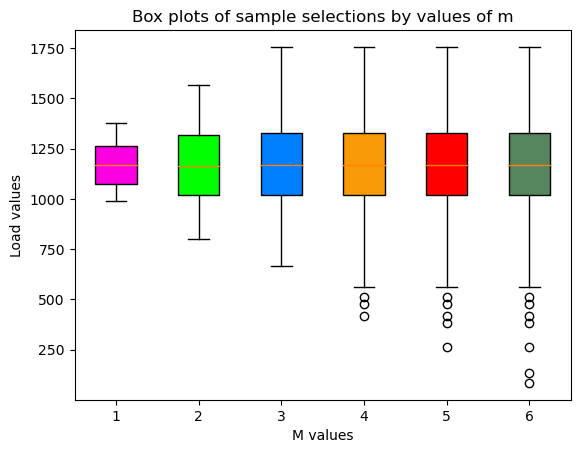

In [7]:
import matplotlib.pyplot as plt
import distinctipy

# List of values for m
ms = [1, 2, 3, 4, 5, 6]

# Get total number of samples
total_number_samples = array.shape[0]

# Array of sample values each different subsets of entire dataset
arrays_no_outliers = []
for m in ms:
    array_subset = reject_outliers(array[:, 0], m)
    arrays_no_outliers.append(array_subset)
    print(f"m = {m}: {len(array_subset)} samples ({total_number_samples-len(array_subset)} \"outliers\" removed)")

# Boxplot with each sample subset distribution represented by a different box
fig, ax = plt.subplots()
# Apple labels on x axis as m values
box = ax.boxplot(arrays_no_outliers, patch_artist=True, labels=ms) 

# Get unique color for each m value (in ms)
colors = distinctipy.get_colors(len(ms))

# Apply the colors to the boxplot boxes
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    
# Label plot
plt.title("Box plots of sample selections by values of m")
plt.xlabel("M values")
plt.ylabel("Load values")

plt.show()

Select preferred value of m

Original sample count: 48048
Downsized to chosen  : 48040 (8 removed)
Samples: [ 970.345   912.1755  900.2688 ... 1081.568  1041.624  1013.5683]


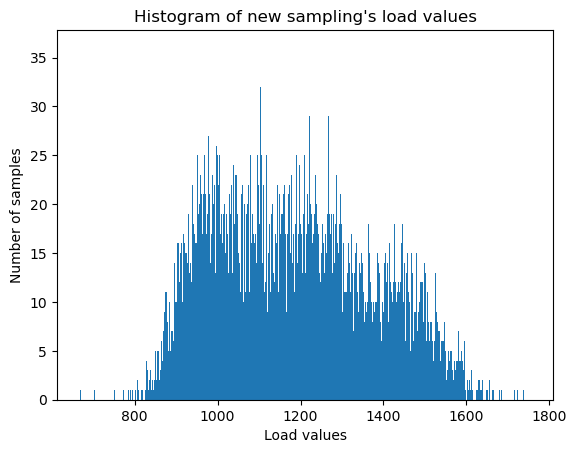

In [8]:
from math import ceil

# Preferred value of m
m =  2 # 0 = None, 1 = 29620, 2 = 47187, 3 = 48040, 4 = 48044, 5 = 48046, 6 = 48048

# Get the array subset matching the m value selected 
array_no_outliers = arrays_no_outliers[ms.index(3)]

# Get new sample count
new_sample_count = len(array_no_outliers)

# Get sample count change
count_diff = total_number_samples - new_sample_count

print(f"Original sample count: {total_number_samples}")
print(f"Downsized to chosen  : {new_sample_count} ({count_diff} removed)")
print(f"Samples: {array_no_outliers}")

# Set number of bins for histogram
num_bins = ceil(total_number_samples / 10)

# Plot the histogram
plt.hist(array_no_outliers, bins=num_bins)
plt.title("Histogram of new sampling's load values")
plt.xlabel("Load values")
plt.ylabel("Number of samples")

plt.show()

## Nat_demand Change Statistics

### Pull out nat_demand (load) as a list for easier list comprehensions

In [9]:
# Get the nat_demand (load) as list for easy list comprehension
column_as_list = array_no_outliers.tolist()

# Get the length of the data (total number of samples)
total_number_samples = len(column_as_list)

print(f"Total sample count: {total_number_samples}")
print(f"First 10 samples: {column_as_list[:10]}")

Total sample count: 48040
First 10 samples: [970.345, 912.1755, 900.2688, 889.9538, 893.6865, 879.2323, 932.4876, 1048.972, 1167.9074, 1257.5069]


### Compute load changes 

Get differences of all prior and next load values 

In [10]:
import numpy as np

# Creat new list of load change between next index and previous via list comprehension 
change_list = [column_as_list[i + 1] - column_as_list[i] for i in range(total_number_samples - 1)]

# Get nump array of change list 
chang_array = np.array(change_list)

print(f"Load changes: shape = {chang_array.shape}")
print(chang_array[:5])

Load changes: shape = (48039,)
[-58.1695 -11.9067 -10.315    3.7327 -14.4542]


### Get 5-summary numbers by change direction +, -, and 0

Separate negative, positive, and no change values

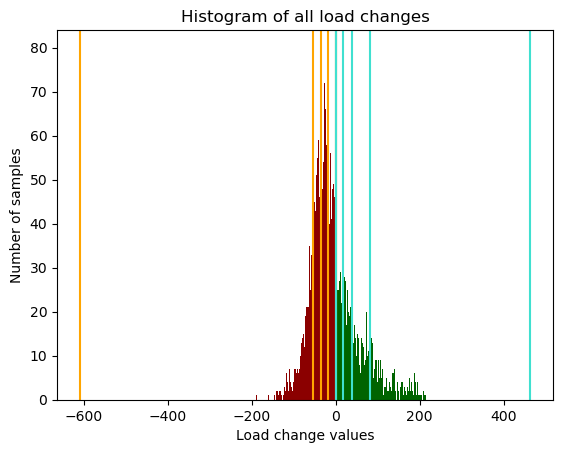

Negatives: Min = -609.49150, Q1 = -52.87627, Q2 = -34.09940, Q3 = -18.71302, Max = -0.00070
No changes: count = 0
Positives: Min = 0.00160, Q1 = 17.25800, Q2 = 39.24450, Q3 = 80.65290, Max = 463.76650


In [11]:
import matplotlib.pyplot as plt
from math import ceil

# Get array of only the negative change values
negative_changes = chang_array[chang_array < 0]

no_changes = chang_array[chang_array == 0]

positive_changes = chang_array[chang_array > 0]

# Get the min and max values for setting the plot x range
neg_min_value = np.min(negative_changes)
neg_max_value = np.max(negative_changes)

pos_min_value = np.min(positive_changes)
pos_max_value = np.max(positive_changes)

# Calculate Q1, Q2, Q3
neg_q1 = np.percentile(negative_changes, 25)
neg_q2 = np.percentile(negative_changes, 50)
neg_q3 = np.percentile(negative_changes, 75)

pos_q1 = np.percentile(positive_changes, 25)
pos_q2 = np.percentile(positive_changes, 50)
pos_q3 = np.percentile(positive_changes, 75)

# Set number of bins for the histogram
num_bins = ceil(total_number_samples / 10)

# Create a histogram of the array
plt.hist(negative_changes, bins=num_bins, color='darkred')

plt.hist(positive_changes, bins=num_bins, color='darkgreen')

# Create vertical lines at each of Five-number summary
neg_line_color = 'orange'
plt.axvline(x=neg_min_value, color=neg_line_color)
plt.axvline(x=neg_q1, color=neg_line_color)
plt.axvline(x=neg_q2, color=neg_line_color)
plt.axvline(x=neg_q3, color=neg_line_color)
plt.axvline(x=neg_max_value, color=neg_line_color)

zero_line_color = 'gray'
plt.axvline(x=0, color=zero_line_color)

pos_line_color = 'turquoise'
plt.axvline(x=pos_min_value, color=pos_line_color)
plt.axvline(x=pos_q1, color=pos_line_color)
plt.axvline(x=pos_q2, color=pos_line_color)
plt.axvline(x=pos_q3, color=pos_line_color)
plt.axvline(x=pos_max_value, color=pos_line_color)

# Label plot
plt.title("Histogram of all load changes")
plt.xlabel("Load change values")
plt.ylabel("Number of samples")

plt.show()

print(f"Negatives: Min = {neg_min_value:.5f}, Q1 = {neg_q1:.5f}, Q2 = {neg_q2:.5f}, "
      f"Q3 = {neg_q3:.5f}, Max = {neg_max_value:.5f}")
print(f"No changes: count = {len(no_changes)}")
print(f"Positives: Min = {pos_min_value:.5f}, Q1 = {pos_q1:.5f}, Q2 = {pos_q2:.5f}, "
      f"Q3 = {pos_q3:.5f}, Max = {pos_max_value:.5f}")

## Customized Markov Chain

### Define state space

Number of months = 12 (Jan = 0, Feb = 1, ..., Dec = 11)
<br>

7 different possible changes in 'nat_demand' (load):
* 0 = larger decrease  
    - 1st quartile of negatives
* 1 = avg decrease      
    - Median of negatives
* 2 = smaller decrease   
    - 3rd quartile of negatives
* 3 = no change         
    - 0
* 4 = smaller increase  
    - 1st quartile of positives
* 5 = avg increase      
    - Median of positives
* 6 = larger increase   
    - 3rd quartile of positives


Therefore a state will be a unique key of **(month number, change number)**

State is unique key of (month, change)
<br>

NOTE: the key will used as indexing of the state to a single matrix holding all the possible states

In [12]:
# Number of change states (described above)
num_changes = 7

# Targets for each states predicted change to cur load valuation
all_targets = [neg_q1, neg_q2, neg_q3, 0, pos_q1, pos_q2, pos_q3]

class State:    
    times_in_state = 0      # Number of times the model has been in this state
    total_load = 0          # The running load of all time state is visited 
    prev_load = 0           # The last seen load value
    
    # Class constructor
    def __init__(self, i, j, num_changes):
        self.month = i
        self.change = j
        self.same_month_trans_counts = np.zeros(num_changes)  # transition probabilities for same month changes
        self.next_month_trans_counts = np.zeros(num_changes)  # transition probabilities for next month changes
    
    # Currently went to this node based on training observation
    def visit(self, load):
        self.times_in_state += 1
        self.total_load += load
        self.prev_load = load
    
    # Used for prediction load from previous state to this one 
    def get_load(self, cur_load):
        return cur_load + all_targets[self.change]
    
    # Function to print out Node object instance info for checking
    def printOut(self):
        if self.times_in_state > 0:
            avg = self.total_load/self.times_in_state
        else:
            avg = self.prev_load
        print(f"State: ({self.month}, {self.change}), Visits: {self.times_in_state}, "
             f"Prev load (avg): {self.prev_load} ({avg})\n"
             f"\tMonth {self.month} transitions: {self.same_month_trans_counts}\n"
             f"\tMonth {(self.month+1)%12} transitions: {self.next_month_trans_counts}"
        )
    
    # Returns top transition change pick based on the current stochastic model 
    def get_state_transition_pred(self, same_month):
        
        # Month is staying the same
        if same_month:
            trans_counts = self.same_month_trans_counts
            
        # Month is moving to the next month 
        else:
            trans_counts = self.next_month_trans_counts
        
        # Get the index of top pick (largest number of times moved to that change from this one)
        top_change_pick = np.argmax(trans_counts)
        
        # If been in this state at least once
        if self.times_in_state > 0:
            
            # Will have a confidence above indifferent (1/num_changes%)
            prob_top_pick = np.max(trans_counts) / self.times_in_state
            
        else:
            # Confidence is indifferent (same for all possible changes
            prob_top_pick = 1/len(self.same_month_trans_counts)
        
        # Return top change pick and associated confidence
        return top_change_pick, prob_top_pick

Test instance print function formatting

In [13]:
# Creat basic state for month 0, change 3 (none) and with 7 possible changes
state = State(0, 3, 7)

# Initial state unvisited
state.printOut()

# First visit
state.visit(1000)
state.printOut()

# Another visit
state.visit(500)
state.printOut()

State: (0, 3), Visits: 0, Prev load (avg): 0 (0)
	Month 0 transitions: [0. 0. 0. 0. 0. 0. 0.]
	Month 1 transitions: [0. 0. 0. 0. 0. 0. 0.]
State: (0, 3), Visits: 1, Prev load (avg): 1000 (1000.0)
	Month 0 transitions: [0. 0. 0. 0. 0. 0. 0.]
	Month 1 transitions: [0. 0. 0. 0. 0. 0. 0.]
State: (0, 3), Visits: 2, Prev load (avg): 500 (750.0)
	Month 0 transitions: [0. 0. 0. 0. 0. 0. 0.]
	Month 1 transitions: [0. 0. 0. 0. 0. 0. 0.]


### Train and make predictions

Define change targets

In [14]:
# Get negative change targets as a list
decrease_targets = [neg_q1, neg_q2, neg_q3]

# Get positive change targets as a list
increase_targets = [pos_q1, pos_q2, pos_q3]

# Get list of all change targets
all_targets = [neg_q1, neg_q2, neg_q3, 0, pos_q1, pos_q2, pos_q3]

print(f"All targets:\n{[round(target, 3) for target in all_targets]}")

All targets:
[-52.876, -34.099, -18.713, 0, 17.258, 39.245, 80.653]


Continue training from 2nd sample, using 1st (starting state) as prior conditions

In [15]:
from sklearn.metrics import r2_score

num_months = 12

# Class for the Markov Chain model
class MarkovChain():
    
    # Constructor initializes the needed transition matrix automatically
    def __init__(self, n, m):
        self._getTransitionMatrix(n, m)
    
    # Initializes a transition matrix based on constructor parameters
    def _getTransitionMatrix(self, n, m):
        
        # Create empty array of dimensions number_months by num_changes (12 by 7) to store State object references
        transition_matrix = np.empty((n, m), dtype=State)

        # for each month [0-11]
        for i in range(n):

            # For each change [0-6]
            for j in range(m):

                # Create a state object instance initialized with constant num_changes
                state = State(int(i), j, m)

                # Put the State instance in the transition_matrix
                transition_matrix[i][j] = state
        
        # Initialize instance variable to created matrix
        self.transition_matrix =  transition_matrix

    # Method to iterate over data samples and make predictions while updating the model to keep track of prior observations/state transitions
    def predict_and_train(self, sample_set, prnt_every=10000):
        
        # Get the starting month
        starting_month = int(sample_set[0, 1])

        # Set starting change to NO CHANGE (since no previous information)
        starting_change = 3

        # Get starting state from transition matrix using key scheme
        starting_state = self.transition_matrix[starting_month, starting_change]

        # Get starting load from first sample
        starting_load = sample_set[0, 0]

        # Visit the starting state passing cur load
        starting_state.visit(starting_load)

        # Set prev state as the starting
        prev_state = starting_state
        
        # set up lists to add predictions to
        preds, trues = [], []

        # For each sample in training set except the first (used to seed start)
        for i, sample in enumerate(sample_set[1:]):  # start at second training sample

            # Offset i to reflect skipping 1
            i+=1

            # Get the cur and prev month and load values
            cur_month = int(sample[1])
            cur_load = sample[0]
            prev_month = prev_state.month
            prev_load = prev_state.prev_load

            # Compute load change
            load_change = cur_load - prev_load

            # Determine which change the current change is closest to target wise
            closest_target = min(all_targets, key=lambda x: abs(x - load_change))

            # Set change transition target to index of the closest value 
            change_target = all_targets.index(closest_target)

            # Boolean if month is same between prev and cur
            same_month = False

            # CHeck if staying in the same month
            if cur_month == prev_month: 

                same_month = True

                # Increment change target tally of the state 
                prev_state.same_month_trans_counts[change_target] += 1

            # later month
            elif cur_month != prev_month: 

                # Check if valid month transition [0-11] and just 1 ahead
                if cur_month == (prev_month + 1) % num_months:  # next month (roll over Dec/11 to Jan/0)

                    # Increment change target tally of the state 
                    prev_state.next_month_trans_counts[change_target] += 1

                # Jumped ahead more than one month, or backwards, or invalid month (11 -> 0 valid)
                else:  
                    # Stop execution because training will be invalid
                    raise ValueError("Encountered an invalid forward state transition from "
                                     , prev_month, "-> ", cur_month,".")

            # Get predicted next change and associated probability (confidence)
            predicted_next_change, prob = prev_state.get_state_transition_pred(same_month)

            # Get the target month (month of next sample to predict), same or next
            next_index = (i+1) % len(sample_set)
            next_sample_month = int(sample_set[next_index][1])

            # Get the predicted next state using predicted change and known target month
            predicted_next_state = self.transition_matrix[next_sample_month, predicted_next_change]

            # Get prediction for next load value
            predicted_next_load = predicted_next_state.get_load(cur_load)

            # Add prediction to the running predictions list
            preds.append(predicted_next_load)

            # Get the actual next load
            actual_next_load = sample_set[next_index][0]
            
            # Add the actual next load to actuals running list
            trues.append(actual_next_load)

            # Compute the percentage difference prediction is from the "true" value
            predict_diff = abs((actual_next_load - predicted_next_load) / actual_next_load * 100)

            # Calculate R-squared
            if len(preds) > 1:
                r2 = r2_score(trues, preds)
            
            # Metric is considered undefined for single pair
            else:
                r2 = "undefined"

            # Get the state that reflects current load change
            cur_state = self.transition_matrix[cur_month, change_target]
            cur_state.visit(cur_load)

            # Print out extra info by specified iteration cycle for checking
            if i % prnt_every == 0:  
                print(f"i = {i}/{len(sample_set)-1}")
                print(f"Month: ({prev_month} -> {cur_month}), Load: ({prev_load} -> {cur_load})")
                print(f"Load change: {load_change} -> {closest_target}, Change type: {change_target}")
                print("Prev state:")
                prev_state.printOut()
                print("Cur state:")
                cur_state.printOut()
                print(f"Predicted change: {predicted_next_change}, Actual change: {change_target}")
                print(f"Prediction: {predicted_next_load:.2f}, Actual: {actual_next_load:.2f}, % Difference: {predict_diff:.2f} %")
                print("-----------------------------------------------------------------------------\n") 

            # Print out current iteration, relative progress percentage and running r-square measure across the entire set
            print(f"i = {i}/{len(sample_set)-1} ({i/len(sample_set)*100:.2f} %): r2 = {r2}", end="\r")

            # Set previous state to current state for next iteration
            prev_state = cur_state
        
        # once all samples have been processed, return predictions and associated true load values
        return preds, trues

Create instance of Markov chain for number of months and number of changes.

Then start processing the data (array) and make a prediction for the next samples load.

The prediction requires sight of the previous load, the current load, and the stochastic state transitions observed previously.

In [16]:
markov_chain = MarkovChain(n=num_months, m=num_changes)
preds, trues = markov_chain.predict_and_train(array, prnt_every=10000)

i = 10000/48047(20.81 %): r2 = 0.9007619251014845
Month: (1 -> 1), Load: (1415.3073 -> 1278.8272)
Load change: -136.4801 -> -52.87627499999985, Change type: 0
Prev state:
State: (1, 0), Visits: 212, Prev load (avg): 1278.8272 (1120.285364150943)
	Month 1 transitions: [104.  57.  24.  13.   6.   6.   1.]
	Month 2 transitions: [0. 0. 0. 0. 0. 0. 0.]
Cur state:
State: (1, 0), Visits: 212, Prev load (avg): 1278.8272 (1120.285364150943)
	Month 1 transitions: [104.  57.  24.  13.   6.   6.   1.]
	Month 2 transitions: [0. 0. 0. 0. 0. 0. 0.]
Predicted change: 0, Actual change: 0
Prediction: 1225.95, Actual: 1250.06, % Difference: 1.93 %
-----------------------------------------------------------------------------

i = 20000/48047 (41.62 %): r2 = 0.9013595891084699
Month: (3 -> 3), Load: (1052.9207 -> 1116.0039)
Load change: 63.08320000000003 -> 80.65290000000005, Change type: 6
Prev state:
State: (3, 6), Visits: 263, Prev load (avg): 1116.0039 (1263.6897939163484)
	Month 3 transitions: [  2.  

Set up a function to plot predictions versus actual values.

Put a vertical line at each demarcation point between years groupings.

In [17]:
# Get unique years in the dataset and count per year 
years, year_counts = np.unique(array[:, 2], return_counts=True)

print(f"Years: {years}")
print(f"Counts: {year_counts}")

# generate visually distinct colors for each year
colors = distinctipy.get_colors(len(years))

# Function to plot the preds vs actual load values
def plotPredsVersusActs(preds, acts):
    line_width = 0.5
    plt.plot(preds, label='Predictions', linewidth=line_width)
    plt.plot(trues, label='Actual', linewidth=line_width)
    plt.legend()
    plt.title("Predictions vs. Actual load values")
    plt.xlabel("Sample Index")
    plt.ylabel("Load value")
    
    # Place vertical lines between each sample group of same year 
    index = 0
    for i, year in enumerate(years):
        index += year_counts[i]
        plt.axvline(x=index, color=colors[i], label=year)
        
    plt.show()

Years: [2015. 2016. 2017. 2018. 2019. 2020.]
Counts: [8711 8784 8760 8760 8760 4273]


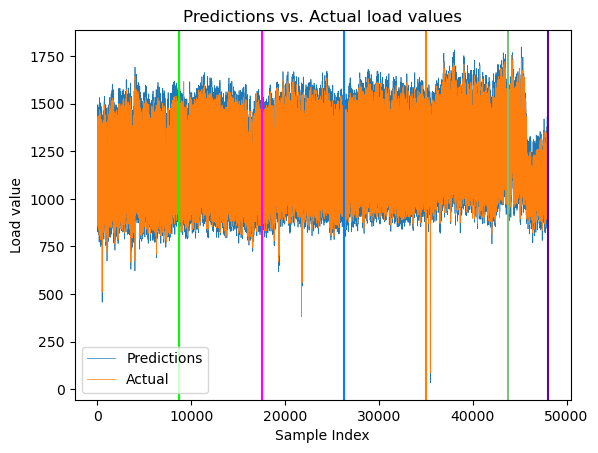

In [18]:
plotPredsVersusActs(preds, trues)